<a href="https://colab.research.google.com/github/VictoriaOG1/Machine-Learning/blob/main/draft3_proyecto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project
### Machine Learning
##### Members: Alejandra Ospina (00212243), Pamela Mena(), Paúl Quimbita() 
##### Date: 2023-05-10

## Introduction
*Introducción va aquí* 

## Desarrollo

#### Import libraries

In [1]:
import tensorflow as tf
print(tf.__version__)

2023-05-06 20:22:09.759027: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.10.0


In [2]:
import numpy as np 
import pandas as pd 
import re
import matplotlib.pyplot as plt 
import nltk
import gensim
import sklearn
import tensorflow as tf
from sklearn.metrics import classification_report, roc_auc_score
from tensorflow import keras 
from sklearn.manifold import TSNE
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from tabulate import tabulate
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.pipeline import Pipeline
nltk.download('stopwords')
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import warnings
warnings.simplefilter('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/Alejandra/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Preprocessing
#### Import Dataset

In [3]:
#Read dataset
dataset = pd.read_csv("Tweets.csv")
dataset.columns = ['textID','text','selected_text', 'sentiment']

#Get columns selected_text and sentiment
dataset_text_x = dataset['selected_text']
dataset_target_y = dataset['sentiment']

#Data visualization 
headers = ['selected_text', 'sentiment']
complete_table = np.column_stack([dataset_text_x, dataset_target_y]) 
table = tabulate(complete_table[0:19,:], headers, tablefmt="rst")
print ("Visualizing first 20 rows")
print(table)


Visualizing first 20 rows
==========================================================================================================  ===========
selected_text                                                                                               sentiment
==========================================================================================================  ===========
I`d have responded, if I were going                                                                         neutral
Sooo SAD                                                                                                    negative
bullying me                                                                                                 negative
leave me alone                                                                                              negative
Sons of ****,                                                                                               negative
http://www.dothebouncy.com/smf -

#### Clean text

In [4]:
# Get columns selected_text and sentiment
selected_text = np.array(dataset['selected_text'].astype(str))
sentiment = np.array(dataset['sentiment'])

# Initialize an empty list to hold the cleaned selected text
cleaned_selected_text = []

# Define a regular expression pattern to match punctuation, symbols, and URLs
pattern = r'[^\w\s]|http\S+'

# Iterate through each selected text in the dataset
for text in selected_text:
    # Use regular expressions to remove punctuation, symbols, and URLs
    cleaned_text = re.sub(pattern, '', text)
    # Append the cleaned selected text to the list and lowercase the text
    cleaned_selected_text.append(cleaned_text.lower())

# Print the first 10 cleaned selected texts
print(cleaned_selected_text[:20])

['id have responded if i were going', 'sooo sad', 'bullying me', 'leave me alone', 'sons of ', '  some shameless plugging for the best rangers forum on earth', 'fun', 'soooo high', 'both of you', 'wow u just became cooler', 'as much as i love to be hopeful i reckon the chances are minimal p im never gonna get my cake and stuff', 'like', 'dangerously', 'lost', 'test test from the lg env2', 'uh oh i am sunburned', 'sigh', 'sick', 'onna', 'hes just not that into you']


#### Tokenize text and encode sentiments

If sentiment is positive it corresponds to number 2, if neutral number 1 and if negative number 0

In [5]:
# Import the set of stopwords from the nltk library
stop_words = set(stopwords.words('english'))

# Create empty lists to store cleaned tokens and sentiment values
tokenized_tweets = []
encoded_sentiments = []

# Loop through each cleaned text in the "cleaned_selected_text" list
for text in range(len(cleaned_selected_text)):
  
  # Split the cleaned text into a list of individual words
  clean_text = list(cleaned_selected_text[text].split())
  
  # Remove stopwords and words with a length of 1 from the list of words, and store in "clean_tokens"
  clean_tokens = [wrd for wrd in clean_text if wrd not in stop_words and len(wrd) > 1]
  clean_tokens = [wrd for wrd in clean_text if wrd not in stop_words]
  
  # If the cleaned token list is not empty, append it to the "tokens" list and assign the correct encoded sentiment value 
  if len(clean_tokens) > 0:
    tokenized_tweets.append(clean_tokens)
    if sentiment[text] == "negative":
      encoded_sentiments.append(0)
    if sentiment[text] == "neutral":
      encoded_sentiments.append(1)
    if sentiment[text] == "positive":
      encoded_sentiments.append(2)

# Print the list of cleaned tokens, as well as the lengths of the "tokens" and "clean_sentiment" lists
print("Tokenized tweets with length of", len(tokenized_tweets))
print("First five examples: ",tokenized_tweets[:5])
print("\nTokenized tweets with length of", len(encoded_sentiments))
print("First five examples: ", encoded_sentiments[:5])


Tokenized tweets with length of 27279
First five examples:  [['id', 'responded', 'going'], ['sooo', 'sad'], ['bullying'], ['leave', 'alone'], ['sons']]

Tokenized tweets with length of 27279
First five examples:  [1, 0, 0, 0, 0]


#### Word2Vec
Vectorize tweets from string to numbers

Get maximum length of a tweet

In [6]:
# Initialize variables to store the length of the longest tweet and its index
max_length = 0
max_index = None

# Loop through each tweet and compare its length to the current maximum length
for i, tweet in enumerate(tokenized_tweets):
    tweet_length = len(tweet)
    if tweet_length > max_length:
        max_length = tweet_length
        max_index = i

# Print the tweet with the most words
print("The tweet with the most words is:", tokenized_tweets[max_index], "with length of", max_length)

The tweet with the most words is: ['lol', 'haha', 'fresh', 'death', 'lol', 'ha', 'ha', 'love', 'miss', 'u', '2', 'id', 'almost', 'given', 'ï½', 'u', 'cuz', 'u', 'nvr', 'respond', '2me', 'u', 'today', 'luv', 'u2'] with length of 25


Create Word2Vec model and train it 

vector_size: the size of the word vectors to be produced by the model

window: he maximum distance between the current and predicted word within a sentence. 

min_count: ignore all words with a total frequency lower than this.

workers=4: use this many worker threads to train the model (=number of CPU cores)

In [7]:
# Create a Word2Vec model using the Gensim library
model_w2v = Word2Vec(sentences=tokenized_tweets, vector_size=max_length, window=5, min_count=1, workers=4) 

# Train the model on the input data
model_w2v.train(tokenized_tweets, total_examples= len(tokenized_tweets), epochs=20)

(2109510, 2282360)

Visualize embeddings or vocabulary using TSNE

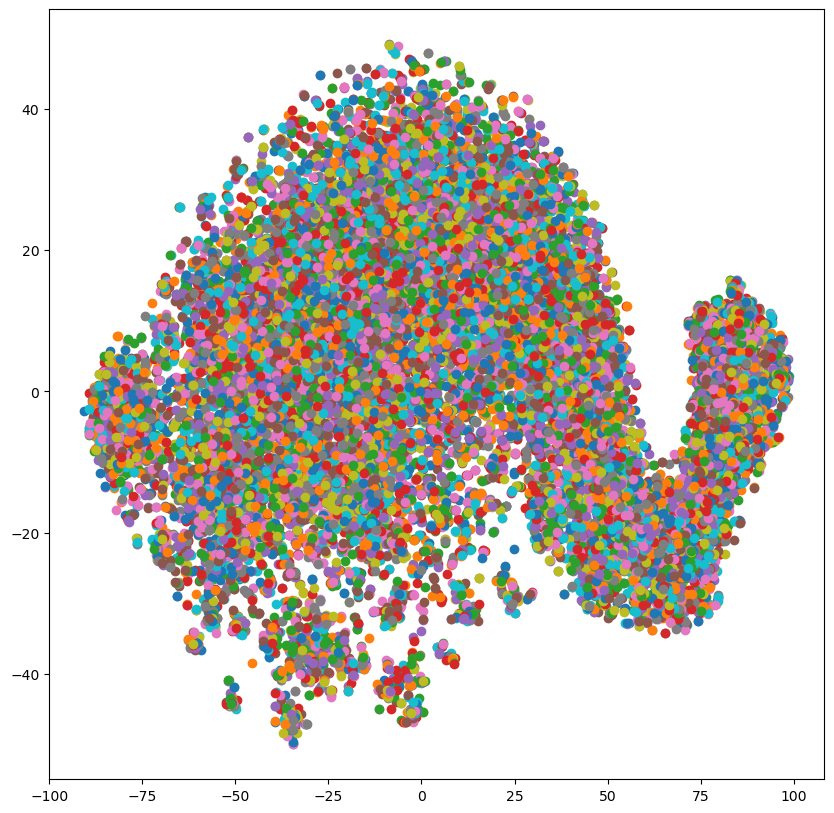

In [8]:
vocabulary = list(model_w2v.wv.index_to_key)
# Visualize embeddings
def plot_embeddings(model):
    # Get word vectors for each word in vocabulary
    X = model.wv[model.wv.index_to_key]
    
    # Use t-SNE to reduce dimensionality of embeddings to 2D
    tsne = TSNE(n_components=2)
    X_tsne = tsne.fit_transform(X)
    
    # Plot embeddings
    plt.figure(figsize=(10, 10))
    for i in range(len(vocabulary)):
        plt.scatter(X_tsne[i, 0], X_tsne[i, 1])
    plt.show()

plot_embeddings(model_w2v)

From tokens to word vector using model of Word2Vec

In [9]:
# Define a function to create a word vector for a given list of tokens
def word_vector(tokens, size):
    # Create a vector of zeros with the specified size
    vec = np.zeros(size).reshape((1, size))
    # Initialize a counter for the number of words
    count = 0.
    # Loop over each word in the list of tokens
    for word in tokens:
        try:
            # Add the vector for the current word to the running total
            vec += model_w2v.wv[word].reshape((1, size))
            # Increment the word count
            count += 1.
        except KeyError: # Handling the case where the token is not in the vocabulary
            continue
    # Divide the vector by the number of words to get the average
    if count != 0:
        vec /= count
    # Return the resulting vector
    return vec

In [10]:
# Create a NumPy array to hold the word vectors for each tokenized tweet
wordvec_arrays = np.zeros((len(tokenized_tweets), max_length))

# Loop over each tokenized tweet and compute the corresponding word vector
for i in range(len(tokenized_tweets)):
    # Use the previously defined word_vector() function to compute the word vector
    wordvec_arrays[i,:] = word_vector(tokenized_tweets[i], max_length)

#Print an example
print(wordvec_arrays[0])

[ 0.80845228 -0.84760004 -0.36153003 -0.67910246  0.03094124  0.19238553
  0.54653978  0.75352643 -1.32486133 -1.09197834 -0.20902713 -1.15680458
  0.70519763  0.73694275 -0.2073244   0.658956    0.64150582  0.95899451
  0.08470843  1.59455581 -0.4325473  -0.0333803  -0.01287144  1.2767515
  0.54046566]


#### Balance dataset

SMOTE (Synthetic Minority Over-sampling Technique) is a popular oversampling technique that is used to address the class imbalance problem in binary classification. Class imbalance occurs when the number of instances of one class is much lower than the number of instances of the other class in the training data. SMOTE is useful when the number of minority class examples is limited and a simple random oversampling technique may lead to overfitting. It helps to create a more diverse set of synthetic examples and can improve the generalization performance of machine learning models. However, it should be noted that SMOTE can also introduce noise and may not always improve the performance of a classifier. Therefore, it is important to evaluate the performance of the machine learning model using appropriate metrics after applying SMOTE.

In [11]:
# Instantiate SMOTE
smote = SMOTE()

# Resample the dataset using SMOTE
X_resampled, y_resampled = smote.fit_resample(wordvec_arrays, encoded_sentiments)

In [12]:
# Both targets to dataframes
y_df_before = pd.DataFrame(encoded_sentiments)
y_df_after = pd.DataFrame(y_resampled)

# Compare the new class distribution with the previous one
print("Before:\n", y_df_before.value_counts(), "\n")
print("After:\n", y_df_after.value_counts())

Before:
 1    11058
2     8564
0     7657
dtype: int64 

After:
 0    11058
1    11058
2    11058
dtype: int64


In [13]:
X_resampled = np.array(X_resampled)
y_resampled = np.array(y_resampled)

#### Data normalization and feature selection

I suggested min-max normalization because it is a simple and widely used method for scaling data to a common range. It can be effective for cases where the range of the input features is known and relatively small, as is often the case in tweet datasets.Min-max normalization preserves the shape of the original distribution while scaling the data to a common range. This can be important for machine learning algorithms that are sensitive to the shape of the input data distribution.

Univariate feature selection is a method of feature selection that selects the best features based on their individual relationship with the target variable, without considering the interactions among the features. It is a simple yet effective method that can help reduce the dimensionality of high-dimensional datasets and improve the performance of machine learning models.

In [14]:
preprocessing_pipeline = Pipeline([
    ('feature_selection', SelectKBest(mutual_info_classif, k=20)), #Univariate feature selection
    ('normalization', StandardScaler())
])

X_normalized = preprocessing_pipeline.fit_transform(X_resampled, y_resampled)

# Print example
print("Number of features before: ", len(X_resampled[0]), "\t\t Number of features after: ", len(X_normalized[0]), "\n")
print("Example of normalized data: \n", X_normalized[0])

Number of features before:  25 		 Number of features after:  20 

Example of normalized data: 
 [ 0.08304216 -0.21526539 -0.40150653  1.03660874  0.2199964  -0.19471736
 -0.58739915 -1.58547073  0.08740985 -0.07150159  0.8071635  -0.87116421
  1.27505946  1.42207096  1.19313975 -0.67569562 -0.45803593 -0.56515401
  0.89429325 -0.08142281]


#### t-SNE visualization

[-13.051293 -19.206469 -29.522263]


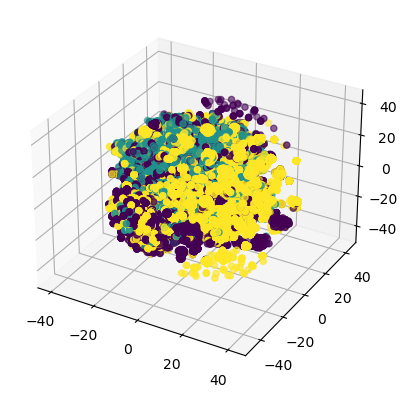

In [15]:
# Crear instancia de TSNE, entrenarlo con los datos, y transformalos
tsne = TSNE(n_components=3, random_state=42)
tsne_data = tsne.fit_transform(X_normalized)

#Imprimir ejemplo de los datos despues de t-SNE
print(tsne_data[45])

# Realizar la gráfica 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tsne_data[:, 0], tsne_data[:, 1], tsne_data[:, 2], c=y_resampled)
plt.show()

### Logistic Regression

In [16]:
#Repeated Stratified KFold
rskf = StratifiedKFold(n_splits=5, random_state = 64, shuffle=True)

# Define a pipeline with a logistic regression model
pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('logreg', LogisticRegression())
])

# Define the hyperparameters to search over
params = {
    'logreg__multi_class': ['multinomial', 'ovr'],
    'logreg__solver': ['lbfgs', 'newton-cg', 'sag', 'saga']
}

# Perform a grid search over the hyperparameters
grid = GridSearchCV(pipe, param_grid=params, cv=rskf, scoring='accuracy', verbose=1)
grid.fit(X_normalized, y_resampled)

# Print the best hyperparameters and mean cross-validation score
print("Best hyperparameters:", grid.best_params_)
print("Best mean cross-validation score:", grid.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best hyperparameters: {'logreg__multi_class': 'ovr', 'logreg__solver': 'newton-cg'}
Best mean cross-validation score: 0.7229457393223783


### Neural Network

In [17]:
def create_model():
  # Define a Keras sequential model with 3 dense layers
  model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(3, activation='softmax')
  ])

  # Compile the model with the Adam optimizer, sparse categorical crossentropy loss, and accuracy metric
  model.compile(optimizer=tf.optimizers.Adam(),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  
  return model

In [18]:
accuracy_scores = []
auc_roc_scores = []
precision_scores = []
recall_scores = []
f1_scores_macro = []
f1_scores_weighted = []

#Repeated Stratified KFold
data_selection = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=34)

for i, (train_index, test_index) in enumerate(data_selection.split(X_normalized,y_resampled)):
  nn_model = create_model()
  nn_model.fit(X_normalized[train_index], y_resampled[train_index])
  nn_model.evaluate(X_normalized[test_index], y_resampled[test_index])
  y_predict = nn_model.predict(X_normalized[test_index])
  y_predict_labels = np.argmax(y_predict, axis=1)
  
  # Compute classification report
  report = classification_report(y_resampled[test_index], y_predict_labels, output_dict=True)
    
  # Append the scores to the corresponding list
  accuracy_scores.append(report['accuracy'])
  precision_scores.append(report['macro avg']['precision'])
  recall_scores.append(report['macro avg']['recall'])
  auc_roc_scores.append(roc_auc_score(y_resampled[test_index], y_predict, multi_class='ovo', average='macro'))
  f1_scores_macro.append(report['macro avg']['f1-score'])
  f1_scores_weighted.append(report['weighted avg']['f1-score'])

# Print the results
print(f'Accuracy: {np.mean(accuracy_scores):.3f} ± {np.std(accuracy_scores):.3f}')
print(f'AUC ROC: {np.mean(auc_roc_scores):.3f} ± {np.std(auc_roc_scores):.3f}')
print(f'Precision: {np.mean(precision_scores):.3f} ± {np.std(precision_scores):.3f}')
print(f'Recall: {np.mean(recall_scores):.3f} ± {np.std(recall_scores):.3f}')
print(f'F1 score (macro avg): {np.mean(f1_scores_macro):.3f} ± {np.std(f1_scores_macro):.3f}')
print(f'F1 score (weighted avg): {np.mean(f1_scores_weighted):.3f} ± {np.std(f1_scores_weighted):.3f}')


2023-05-06 20:40:19.074926: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-06 20:40:19.075610: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


300/933 [========>.....................] - ETA: 2:27 - loss: 0.7198 - accuracy: 0.6934

KeyboardInterrupt: 